# 4.7 Lab: Classification Methods

## 4.7.1 The Stock Market Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import math
from patsy import dmatrices
import statsmodels.discrete.discrete_model as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import preprocessing

import seaborn as sns
sns.set_theme()
sns.set_style("ticks")


In [3]:
Smarket = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Smarket.csv', header=0)

In [4]:
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [5]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [6]:
Smarket.shape

(1250, 9)

In [7]:
# for panda data frame, there is a method corr to compute pairwise correlation between numerical variables
Smarket.corr()
# as one would expect, the correlations between the lag variables and today’s returns are close to zero. 


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


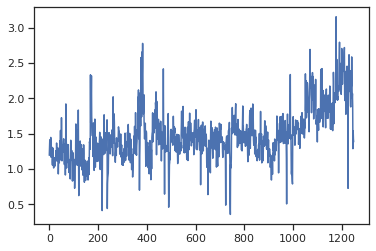

In [8]:
# take a look at volume column
plt.plot(Smarket.iloc[:, 6])
# or plt.plot(Smarket[['Volume']])
plt.show()

## 4.7.2 Logistic Regression
There are some known complications that in Sklearn about applying parameter regularization. This can be aviod to set the tuning parameter 'C' to a large number. Here to be consistent with R output, I decieded to use Statsmodels.

In [9]:
y, X = dmatrices('Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume', Smarket, return_type = 'dataframe')
print(y)

      Direction[Down]  Direction[Up]
0                 0.0            1.0
1                 0.0            1.0
2                 1.0            0.0
3                 0.0            1.0
4                 0.0            1.0
...               ...            ...
1245              0.0            1.0
1246              1.0            0.0
1247              0.0            1.0
1248              1.0            0.0
1249              1.0            0.0

[1250 rows x 2 columns]


In [56]:
# since we are more interested in stock marketing up, we take the second column of y as our response variable 
# we build a model to predict whether the direction will be up. 
logit = sm.Logit(y.iloc[:,1], X)
print(logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          Direction[Up]   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Wed, 14 Sep 2022   Pseudo R-squ.:                0.002074
Time:                        11:15:03   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.

In [11]:
# to extract the parameters directly
logit.fit().params

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


Intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [12]:
# to extract the probability of the market going up for the first 10 instances
logit.fit().predict()[0:10] 

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [13]:
# in order to make a prediction as to whether the market will go up or down on a particular day, 
# we must convert these predicted probabilities into class labels, Up (1) or Down (0).
# we will do this by threshold the probability by a predefined threshold 
threshold = 0.5 
predict_label = pd.DataFrame(np.zeros(shape=(1250,1)), columns = ['label'])
predict_label.iloc[logit.fit().predict()>threshold] = 1

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


In [14]:
# we can evalue the TRAINING result by constructing a confusion matrix 
confusion_matrix(y.iloc[:,1], predict_label.iloc[:,0])

array([[145, 457],
       [141, 507]])

In [15]:
# the diagonal elements of the confusion matrix indicate correct predictions, while the off-diagonals represent incorrect predictions. 
# in this case, logistic regression correctly predicted the movement of the market 52.2% of the time.
print(np.mean(y.iloc[:,1] == predict_label.iloc[:,0]))
# or use the confusion matrix to compute the accuracy 
print(confusion_matrix(y.iloc[:,1], predict_label.iloc[:,0]).diagonal().sum()* 1.0 /confusion_matrix(y.iloc[:,1], predict_label.iloc[:,0]).sum())

0.5216
0.5216


### Train-Validation Split

In [16]:
# in order to better assess the accuracy of the logistic regression model in this setting, 
# we can fit the model using part of the data, and then examine how well it predicts the hold out data. 
# this will yield a more realistic error rate, in the sense that in practice we will be interested in our 
# model’s performance not on the data that we used to fit the model, but rather on days in the future for which the market’s movements are unknown.
Smarket_2005 = Smarket.query('Year >= 2005')
Smarket_train = Smarket.query('Year < 2005')

In [17]:
# we will use the training dataset to build the logistic regression model 
y_train, X_train = dmatrices('Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume', Smarket_train, return_type = 'dataframe')
y_test, X_test = dmatrices('Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume', Smarket_2005, return_type = 'dataframe')

In [18]:
logit = sm.Logit(y_train.iloc[:,1], X_train)
print(logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          Direction[Up]   No. Observations:                  998
Model:                          Logit   Df Residuals:                      991
Method:                           MLE   Df Model:                            6
Date:                Wed, 14 Sep 2022   Pseudo R-squ.:                0.001562
Time:                        11:14:30   Log-Likelihood:                -690.55
converged:                       True   LL-Null:                       -691.63
Covariance Type:            nonrobust   LLR p-value:                    0.9044
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1912      0.334      0.573      0.567      -0.463       0.845
Lag1          -0.0542      0.

In [19]:
preds = logit.fit().predict(X_test)
predict_label = pd.DataFrame(np.zeros(shape=(X_test.shape[0],1)), columns = ['label'])
threshold = 0.5
mark = (preds > threshold).reset_index(drop=True)
predict_label.loc[mark] = 1
confusion_matrix(y_test.iloc[:,1], predict_label.iloc[:,0])

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4


array([[77, 34],
       [97, 44]])

In [20]:
# to get accuracy
np.mean(y_test.iloc[:,1].reset_index(drop=True)==predict_label.iloc[:,0].reset_index(drop=True)) 

# note: we have trained and tested our model on two completely separate data sets: 
# training was performed using only the dates before 2005, and testing was performed 
# using only the dates in 2005. Finally, we compute the predictions for 2005 and compare 
# them to the actual movements of the market over that time period. The results are rather 
# disappointing: the test error rate is 1 - 48% = 52 %, which is worse than random guessing 
# for a balanced data. Of course this result is not all that surprising, given that one 
# would not generally expect to be able to use previous days’ returns to predict future market performance.

0.4801587301587302

In [21]:
# the retrain of the model with Lag1 and Lag2 will be similar to previous steps (I will be brief here). 
y_train, X_train = dmatrices('Direction~Lag1+Lag2', Smarket_train, return_type = 'dataframe')
y_test, X_test = dmatrices('Direction~Lag1+Lag2', Smarket_2005, return_type = 'dataframe')
logit = sm.Logit(y_train.iloc[:,1], X_train)
preds = logit.fit().predict(X_test)
predict_label = pd.DataFrame(np.zeros(shape=(X_test.shape[0],1)), columns = ['label'])
threshold = 0.5
confusion_matrix(y_test.iloc[:,1], predict_label.iloc[:,0])
np.mean(y_test.iloc[:,1].reset_index(drop=True)==predict_label.iloc[:,0].reset_index(drop=True)) # to get accuracy on validation set

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


0.44047619047619047

In [22]:
# another way to deal with logistics regression is to change the threshold value from 0.5 to others. 
# there is an example below with threshold 0.45. 
preds = logit.fit().predict(X_test)
predict_label = pd.DataFrame(np.zeros(shape=(X_test.shape[0],1)), columns = ['label'])
threshold = 0.45
predict_label.loc[(preds > threshold).reset_index(drop=True)] = 1
confusion_matrix(y_test.iloc[:,1], predict_label.iloc[:,0])

# to get accuracy on validation set, we did see an improvment of the accuracy from 0.48 to 0.56
np.mean(y_test.iloc[:,1].reset_index(drop=True)==predict_label.iloc[:,0].reset_index(drop=True)) 

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


0.5595238095238095

## 4.7.3 Linear Discriminant Analysis

In [23]:
# we will use sklearn's implementation of LDA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [24]:
y_train.iloc[:,1].unique()

array([1., 0.])

In [25]:
# the training process 
sklearn_lda = LDA(n_components=1) #creating a LDA object
lda = sklearn_lda.fit(X_train.iloc[:,1:3], y_train.iloc[:,1]) #learning the projection matrix
X_lda = lda.transform(X_train.iloc[:,1:3]) #using the model to project X 
X_labels = lda.predict(X_train.iloc[:,1:3]) #gives you the predicted label for each sample
X_prob = lda.predict_proba(X_train.iloc[:,1:3]) #the probability of each sample to belong to each class

In [26]:
# testing step 
X_test_labels =lda.predict(X_test.iloc[:,1:3])
X_test_prob = lda.predict_proba(X_test.iloc[:,1:3]) 
print(X_test_prob[0:5,:])

[[0.49017925 0.50982075]
 [0.4792185  0.5207815 ]
 [0.46681848 0.53318152]
 [0.47400107 0.52599893]
 [0.49278766 0.50721234]]


In [27]:
# get the accuracy of the test set using default threshold
np.mean(y_test.iloc[:,1]==X_test_labels) 

0.5595238095238095

In [28]:
# let's change the threshod a bit to see whether we can improve the accuracy. 
# the 2nd column of X_test_prob is the probability belongs to UP group. 
# the default value is 0.5, let us first check that. 
threshold = 0.5 
np.mean(y_test.iloc[:,1]==(X_test_prob[:,1]>=threshold))

0.5595238095238095

In [29]:
threshold = 0.48
np.mean(y_test.iloc[:,1]==(X_test_prob[:,1]>=threshold))

0.5634920634920635

## 4.7.4 Quadratic Discriminant Analysis

In [30]:
# it is a little bit of annoying that QDA and LDA have minor difference in their parameter 
# set-up and function names. 
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [31]:
sklearn_qda = QDA(priors=None,store_covariance=True) #creating a QDA object
qda = sklearn_qda.fit(X_train.iloc[:,1:3], y_train.iloc[:,1]) #learning the projection matrix
X_labels = qda.predict(X_train.iloc[:,1:3]) #gives you the predicted label for each sample
X_prob = qda.predict_proba(X_train.iloc[:,1:3]) #the probability of each sample to belong to each class

X_test_labels=qda.predict(X_test.iloc[:,1:3])
X_test_prob = qda.predict_proba(X_test.iloc[:,1:3]) 

print(np.mean(y_test.iloc[:,1]==X_test_labels) )

0.5992063492063492


In [32]:
# again, use dir() to explore all the information stored in lda and qda.
dir(qda)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_feature_names',
 '_check_n_features',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'classes_',
 'covariance_',
 'decision_function',
 'feature_names_in_',
 'fit',
 'get_params',
 'means_',
 'n_features_in_',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'priors',
 'priors_',
 'reg_param',
 'rotations_',
 'scalings_',
 'score',
 'set_params',
 'store_covariance',
 'tol']

In [33]:
print(qda.means_)
print(qda.covariance_)

[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]
[array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]]), array([[ 1.51700576, -0.02787349],
       [-0.02787349,  1.49026815]])]


## 4.7.5 Naive Bayes

In [34]:
# from sklearn.naive_bayes import GaussianNB as NB

In [35]:
NB_class = NB()
NB_class.fit(X_train.iloc[:,1:3], y_train.iloc[:,1])
X_test_labels=NB_class.predict(X_test.iloc[:,1:3])
X_test_prob = NB_class.predict_proba(X_test.iloc[:,1:3]) 
print(np.mean(y_test.iloc[:,1]==X_test_labels))

dir(NB_class) # use dir command to check what Naive Bayes classifier has

0.5952380952380952


['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_X',
 '_check_feature_names',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_joint_log_likelihood',
 '_more_tags',
 '_partial_fit',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_update_mean_variance',
 '_validate_data',
 'class_count_',
 'class_prior_',
 'classes_',
 'epsilon_',
 'feature_names_in_',
 'fit',
 'get_params',
 'n_features_in_',
 'partial_fit',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'priors',
 'score',
 'set_params',
 'sigma_',
 'theta_',
 'var_',
 'var_smoothing']

## 4.7.6 K-Nearest Neighbors

In [36]:
# from sklearn.neighbors import KNeighborsClassifier as KNN

In [37]:
neigh = KNN(n_neighbors= 4) # use n_neighbors to change the # of tune the performance of KNN
KNN_fit = neigh.fit(X_train.iloc[:,1:3], y_train.iloc[:,1]) #learning the projection matrix
X_test_labels=KNN_fit.predict(X_test.iloc[:,1:3])
X_test_prob = KNN_fit.predict_proba(X_test.iloc[:,1:3]) 
print(np.mean(y_test.iloc[:,1]==X_test_labels))

dir(neigh) # use dir command to check what KNN offers

0.5158730158730159


['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_algorithm_metric',
 '_check_feature_names',
 '_check_n_features',
 '_estimator_type',
 '_fit',
 '_fit_X',
 '_fit_method',
 '_get_param_names',
 '_get_tags',
 '_kneighbors_reduce_func',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_tree',
 '_validate_data',
 '_y',
 'algorithm',
 'classes_',
 'effective_metric_',
 'effective_metric_params_',
 'feature_names_in_',
 'fit',
 'get_params',
 'kneighbors',
 'kneighbors_graph',
 'leaf_size',
 'metric',
 'metric_params',
 'n_features_in_',
 'n_jobs',
 'n_neighbors',
 'n_sa

## 4.7.7 Possion Regression

In [38]:
Bikeshare = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Bikeshare.csv', header=0)

In [39]:
print(Bikeshare.head())
print(Bikeshare.shape)

   season mnth  day  hr  holiday  weekday  workingday weathersit  temp  \
0       1  Jan    1   0        0        6           0      clear  0.24   
1       1  Jan    1   1        0        6           0      clear  0.22   
2       1  Jan    1   2        0        6           0      clear  0.22   
3       1  Jan    1   3        0        6           0      clear  0.24   
4       1  Jan    1   4        0        6           0      clear  0.24   

    atemp   hum  windspeed  casual  registered  bikers  
0  0.2879  0.81        0.0       3          13      16  
1  0.2727  0.80        0.0       8          32      40  
2  0.2727  0.80        0.0       5          27      32  
3  0.2879  0.75        0.0       3          10      13  
4  0.2879  0.75        0.0       0           1       1  
(8645, 15)


In [40]:
# first build a linear regression model
lm_bikeshare = smf.ols('bikers ~ mnth + hr + workingday + temp + weathersit', data = Bikeshare).fit()

In [41]:
# check the summary of the model, we may see the coefficients are different from the R output.
# the diff in the coefficients is due to the difference in the way we chose the baseline for the catergotical variables.
# here Python used April as the baseline month - probably due to the alphabetical order of the name of the month.
lm_bikeshare.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 bikers   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     291.1
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:14:34   Log-Likelihood:                -52635.
No. Observations:                8645   AIC:                         1.053e+05
Df Residuals:                    8627   BIC:                         1.054e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      -101.1052      7.269    -13.910      0.000    -115.353     -86.857
mnth[T.Aug]                     -33.1123      6.410     -5.166      0.000     -45.677     -20.547
mnth[T.Dec]                      34.7242      5.908      5.878      0.000      23.144      46.305
mnth[T.Feb]                       5.3621      6.279      0.854      0.393      -6.946      17.670
mnth[T.Jan]                      15.8861      6.731      2.360      0.018       2.691      29.081
mnth[T.July]                    -52.1488      6.769     -7.704      0.000     -65.417     -38.881
mnth[T.June]                    -16.8499      6.343     -2.656      0.008     -29.284      -4.416
mnth[T.March]                     4.4564      5.906      0.755      0.451      -7.121      16.034
mnth[T.May]                      10.3534      5.757      1.798      0.072      -0.932      21.639
mnth[T.Nov]                      32.8573      5.705      5.759      0.000      21.674      44.041
mnth[T.Oct]                      34.6532      5.591      6.198      0.000      23.694      45.613
mnth[T.Sept]                     -3.0572      5.930     -0.516      0.606     -14.681       8.567
weathersit[T.cloudy/misty]      -10.5972      2.729     -3.884      0.000     -15.946      -5.249
weathersit[T.heavy rain/snow]   -62.2356    106.855     -0.582      0.560    -271.698     147.227
weathersit[T.light rain/snow]   -58.2213      4.133    -14.088      0.000     -66.322     -50.120
hr                                6.6441      0.174     38.286      0.000       6.304       6.984
workingday                       -1.1738      2.489     -0.472      0.637      -6.053       3.705
temp                            356.0133     13.007     27.370      0.000     330.516     381.511
==============================================================================
Omnibus:                     1288.401   Durbin-Watson:                   0.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2017.317
Skew:                           1.044   Prob(JB):                         0.00
Kurtosis:                       4.113   Cond. No.                     1.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
# after building the model, we could do other things (i.e. plots, other statistics, RMSE etc.) to further explore the results. 
# here let us get a sense of the RMSE
np.sqrt(((lm_bikeshare.fittedvalues - Bikeshare.bikers)**2).sum()/len(Bikeshare.bikers))

106.65534360848793

In [43]:
# let us go ahead and build a possion regression model 
# instead of use .ols(), we use .glm()
glm_bikeshare = smf.glm('bikers ~ mnth + hr + workingday + temp + weathersit', data = Bikeshare, family=sma.families.Poisson()).fit()

In [44]:
glm_bikeshare.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 bikers   No. Observations:                 8645
Model:                            GLM   Df Residuals:                     8627
Model Family:                 Poisson   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.4404e+05
Date:                Wed, 14 Sep 2022   Deviance:                   6.3504e+05
Time:                        11:14:35   Pearson chi2:                 6.83e+05
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.0118      0.006    476.777      0.000       2.999       3.024
mnth[T.Aug]                      -0.2288      0.005    -48.719      0.000      -0.238      -0.220
mnth[T.Dec]                       0.2981      0.005     59.511      0.000       0.288       0.308
mnth[T.Feb]                      -0.1015      0.006    -17.160      0.000      -0.113      -0.090
mnth[T.Jan]                      -0.1450      0.007    -21.388      0.000      -0.158      -0.132
mnth[T.July]                     -0.3777      0.005    -76.183      0.000      -0.387      -0.368
mnth[T.June]                     -0.1502      0.005    -32.493      0.000      -0.159      -0.141
mnth[T.March]                    -0.0312      0.005     -5.833      0.000      -0.042      -0.021
mnth[T.May]                       0.0508      0.004     11.690      0.000       0.042       0.059
mnth[T.Nov]                       0.2845      0.005     61.782      0.000       0.276       0.294
mnth[T.Oct]                       0.2667      0.004     61.683      0.000       0.258       0.275
mnth[T.Sept]                     -0.0065      0.004     -1.473      0.141      -0.015       0.002
weathersit[T.cloudy/misty]       -0.0308      0.002    -14.233      0.000      -0.035      -0.027
weathersit[T.heavy rain/snow]    -0.6455      0.167     -3.871      0.000      -0.972      -0.319
weathersit[T.light rain/snow]    -0.4728      0.004   -116.934      0.000      -0.481      -0.465
hr                                0.0507      0.000    351.836      0.000       0.050       0.051
workingday                       -0.0128      0.002     -6.573      0.000      -0.017      -0.009
temp                              2.5639      0.010    257.622      0.000       2.544       2.583
=================================================================================================
"""

In [45]:
# here we do another quick look at the training RMSE 
# to judge whether model is better, we would do train/validation split and check the model performance on the validation set.
np.sqrt(((glm_bikeshare.fittedvalues - Bikeshare.bikers)**2).sum()/len(Bikeshare.bikers))

107.73434730516983

## 4.7.8 An Application to Caravan Insurance Data 
This section is removed from the 2nd edition, but keep it as a reference.

In [46]:
Caravan = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Caravan.csv', header=0)

In [47]:
Caravan.shape

(5822, 86)

In [48]:
Caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [49]:
Caravan.describe()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
count,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,...,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000
mean,24.253349,1.110615,2.678805,2.991240,5.773617,0.696496,4.626932,1.069907,3.258502,6.183442,...,0.076606,0.005325,0.006527,0.004638,0.570079,0.000515,0.006012,0.031776,0.007901,0.014256
std,12.846706,0.405842,0.789835,0.814589,2.856760,1.003234,1.715843,1.017503,1.597647,1.909482,...,0.377569,0.072782,0.080532,0.077403,0.562058,0.022696,0.081632,0.210986,0.090463,0.119996
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,1.000000,3.000000,3.000000,7.000000,0.000000,5.000000,1.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,2.000000,4.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,10.000000,5.000000,6.000000,10.000000,9.000000,9.000000,5.000000,9.000000,9.000000,...,8.000000,1.000000,1.000000,2.000000,7.000000,1.000000,2.000000,3.000000,2.000000,2.000000


Scale of the variables matters in KNN ! The core question in KNN is how to define proper distance metric. 
Because the KNN classifier predicts the class of a given test observation by identifying the observations 
that are nearest to it, the scale of the variables matters. Any variables that are on a large scale will 
have a much larger effect on the distance between the observations, and hence on the KNN classifier, 
than variables that are on a small scale. For instance, imagine a data set that contains two variables, 
salary and age (measured in dollars and years, respectively). As far as KNN is concerned, 
a difference of 1,000 in salary is enormous compared to a difference of 50 years in age. 
Consequently, salary will drive the KNN classification results, and age will have almost no effect. 
This is contrary to our intuition that a salary difference of 1, 000 is quite small compared to an age difference of 50 years. 
Furthermore, the importance of scale to the KNN classifier leads to another issue: if we measured salary in Japanese yen, 
or if we measured age in minutes, then we’d get quite different classification results from what we get 
if these two variables are measured in dollars and years. 

A good (debatable) way to handle this problem is to standardize the data so that all standardize 
variables are given a mean of zero and a standard deviation of one. Then all variables will be on a comparable scale.
The scale() function does just scale() this. In standardizing the data, we exclude column 86, 
because that is the qualitative Purchase variable.

In [51]:
predict_label = pd.DataFrame(np.zeros(shape=(Caravan.shape[0],1)), columns = ['label'])
predict_label[Caravan['Purchase'] == 'Yes'] = 1
Caravan_drop = Caravan.drop(labels='Purchase', axis=1)

I took a slightly different approach from the book. 
The training and testing data were splited by index. 
The normalization was done on the train set. 
Afterwards, the same normalization was applied to validate test. 
The code might seem wordy, but it helps clear the logical flow. 

In [53]:
# I took a slightly different approach from the book. The training and testing data were splited by index. 
# the normalization was done on the train set. Afterwards, the same normalization was applied to validate test.  
# the code might seem wordy, but it helps clear the logical flow. 
train_size = 1000
train_index = range(0, train_size)
X_validate = Caravan_drop.iloc[train_index, ]
Y_validate = predict_label.iloc[train_index, ]
X_train = Caravan_drop.iloc[train_size:, ]
Y_train = predict_label.iloc[train_size:, ]


X_train_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_validate_scaled = scaler.transform(X_validate)   

In [54]:
# train with 1 neighbor 
n_neighbors = 1
neigh = KNN(n_neighbors= n_neighbors) # use n_neighbors to change the # of tune the performance of KNN
KNN_fit = neigh.fit(X_train_scaled, Y_train.iloc[:,0]) #learning the projection matrix
X_validate_labels=KNN_fit.predict(X_validate_scaled)
X_validate_prob = KNN_fit.predict_proba(X_validate_scaled) 
print(np.mean(Y_validate.iloc[:,0]==X_validate_labels))
print(confusion_matrix(Y_validate.iloc[:,0], X_validate_labels))

# the rest of this exercise considers all the trade-off between False postive and False negative.  
# the concept of accuracy is NOT always the golden metric for classification problems. 
# precision and recall, sensitivity and specificity, F1 score... are all reasonable metrics to consider. 
# we will discuss more on the concept of trainning, validation and test. 

0.883
[[874  67]
 [ 50   9]]


In [55]:
# End of Chapter 4